# Wellbeing Police

From various subreddit, we have scraped close to 4000 posts. The subreddits include "r/SuicideWatch", "r/BipolarReddit", "r/Anxiety", "r/AnxietyDepression", "r/Depression", and "r/Happy". Each of the subreddit posts currently sitting within its own csv file. We will see what are the fields that are consistent across the CSV files and choose those applicable. Clean up the data, removed the columns not needed. 

As all the scrapes was created from the same script, the columns of the resulting csv are same across the files. 
We will proceed to label them according to the subreddit they came from and combine them into a single dataframe.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import spacy
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import GloVe


from src.utils import color_func, get_mask, search,text_normalization
from src.nn import *

### Data Combination and Labeling

We retrieved posts in “Hot” section from various subreddits:
`r/ptsd`,`r/Anxiety`,`r/SuicideWatch`,`r/depression`,`r/BipolarReddit`,`r/schizophrenia`,`r/EDAnonymous`,`r/EatingDisorders`

In [3]:
path = "./reddit/csvs/"
all_csvs = glob.glob(os.path.join(path, "*.csv"))

all_dfs = []
for filename in all_csvs:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df[["title", "subreddit", "body"]]
    df = df[2:]
    
    # ## manually remove irrelevant pinned posts
    # if df.iloc[0].subreddit in ["ptsd",'Anxiety',"SuicideWatch",'EDAnonymous']: 
    #     df=df[2:]
    # if df.iloc[0].subreddit in ['BipolarReddit','schizophrenia','EatingDisorders']:
    #     df=df[1:]
        
    all_dfs.append(df)

# main_df = pd.concat(all_dfs)
# print(main_df.shape)
# main_df = main_df.drop_duplicates()
# print(main_df.shape)
# main_df = main_df.dropna()
# print(main_df.shape)
# main_df.head()


# main_df["body"] = main_df["title"] + " " + main_df["body"]
# main_df = main_df.drop_duplicates()
# print(main_df.shape)
# main_df = main_df.dropna()
# print(main_df.shape)
# main_df.head()

main_df = pd.concat(all_dfs)
print(main_df.shape)
main_df = main_df.fillna('')
main_df["body"] = main_df["title"] + " " + main_df["body"]
main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df = main_df.dropna()
print(main_df.shape)
main_df.head()


main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df = main_df.dropna()
print(main_df.shape)
main_df.head()


(34785, 3)
(23706, 3)
(23706, 3)
(23706, 3)
(23706, 3)


,title,subreddit,body
2,Processing my trauma requires feeling safe but...,ptsd,Processing my trauma requires feeling safe but...
3,My sister is the strongest person I know. She’...,ptsd,My sister is the strongest person I know. She’...
4,Has anyone else found mushrooms helped?,ptsd,Has anyone else found mushrooms helped? At a p...
5,Interview About War Trauma,ptsd,"Interview About War Trauma Hello, my name is Z..."
6,"Reached Out to 60 Therapists, Only got on Wait...",ptsd,"Reached Out to 60 Therapists, Only got on Wait..."


A few of the subreddit is indicating the same underlying mental problems, we proceed to add an attribute such that these minor differentiation will be grouped for better and easier identification.

<AxesSubplot: title={'center': 'Class Counts'}>

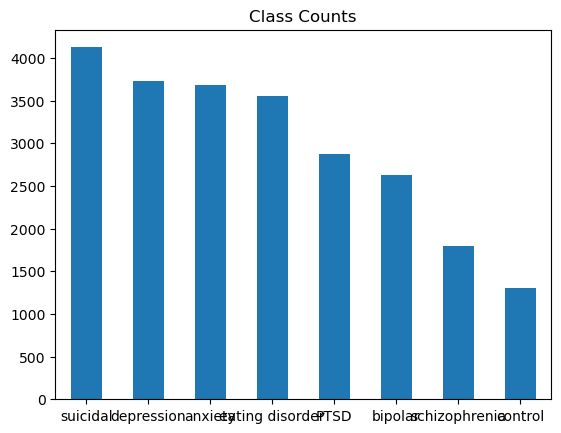

In [4]:
sub_problem_mapping = {
    "ptsd": "PTSD",
    "CPTSD": "PTSD",
    "Anxiety": "anxiety",
    "Anxietyhelp": "anxiety",
    "SuicideWatch": "suicidal",
    "selfharm": "suicidal",
    "depression": "depression",
    "depression_help": "depression", 
    "BipolarReddit": "bipolar", 
    "bipolar": "bipolar",
    "schizophrenia": "schizophrenia",
    "EDAnonymous": "eating disorder",
    "EatingDisorders": "eating disorder",
    "happy": "control",
    "MadeMeSmile": "control"
}

main_df["problem"] = [sub_problem_mapping[s] for s in main_df["subreddit"]]
main_df.head()
main_df["problem"].value_counts().plot.bar(rot=0, title="Class Counts")

#NEED TO DECIDE whether need to drop control.

In [5]:
df_PTSD = main_df[main_df['problem'] == 'PTSD']
df_anxiety = main_df[main_df['problem'] == 'anxiety']
df_suicidal = main_df[main_df['problem'] == 'suicidal']
df_depression = main_df[main_df['problem'] == 'depression']
df_bipolar = main_df[main_df['problem'] == 'bipolar']
df_schizophrenia = main_df[main_df['problem'] == 'schizophrenia']
df_eating_disorder = main_df[main_df['problem'] == 'eating disorder']
df_control = main_df[main_df['problem'] == 'control']

df_PTSD = df_PTSD[:1500]
df_anxiety = df_anxiety[:1500]
df_suicidal = df_suicidal[:1500]
df_depression = df_depression[:1500]
df_bipolar = df_bipolar[:1500]
df_schizophrenia = df_schizophrenia[:1500]
df_eating_disorder = df_eating_disorder[:1500]
# df_control = df_control[:1500]
all_dfs = []
all_dfs.append(df_PTSD)
all_dfs.append(df_anxiety)
all_dfs.append(df_suicidal)
all_dfs.append(df_depression)
all_dfs.append(df_bipolar)
all_dfs.append(df_schizophrenia)
all_dfs.append(df_eating_disorder)
all_dfs.append(df_control)
main_df = pd.concat(all_dfs)

<AxesSubplot: title={'center': 'Class Counts'}>

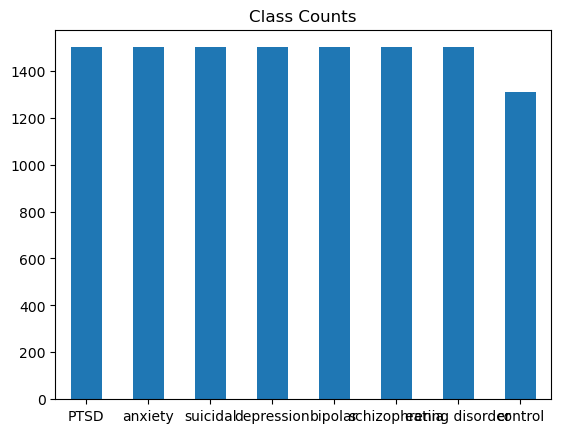

In [6]:
main_df["problem"].value_counts().plot.bar(rot=0, title="Class Counts")

In [7]:

# Normalization codes from the notebook
# Note that we did not include removal of words in brackets as well as odd characters as
# these may denote some emotion (anger for instance may lead to multiple !!!). 
def normalizer(s):
    s = s.lower()                                                   # Lowercase whole sentence
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces
    s = re.sub(r'([.]){2,}', ' ', s)                                # Remove ellipses ...
    s = re.sub(r'([\w.-]+)([,;])([\w.-]+)', '\g<1>\g<2> \g<3>', s)  # Add missing whitespace after , and ;
    s = re.sub(r'(.+)\1{2,}', '\g<1>\g<1>', s)                      # Reduce repeated sequences to 2
    #s = re.sub(r'[\(\[].*?[\)\]]', ' ', s)                          # Remove all words in brackets
    s = re.sub(r'(n\'t)', ' not', s)                                # Resolve contraction "-n't"
    # s = re.sub(r'[^a-zA-Z0-9_-]+', ' ', s)                         # Remove all "odd" characters
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces (again)
    s = s.strip()                                                   # Remove trailing whitespaces
    return s

In [8]:
# Lemmatization was not used as it did not give good results during validation
# A quick intuition as to why is that some similar meaning words can be used to convey different emotions

# Lemmatization codes from provided notebook
# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_lemmatizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_ for word in mytokens ]
    # Removing stop words
    # mytokens = [ word for word in mytokens if word not in stop_words ]
    # return preprocessed list of tokens
    return " ".join(mytokens)

In [9]:
# Stemming was not used as it did not give good results during validation

# Stemming codes from provided notebook
stemmer = PorterStemmer()
tokenizer = get_tokenizer("spacy", "en_core_web_sm")

def nltk_stemmer(s):
    stemmed_words = []
    token_list = tokenizer(s)
    for word in token_list:
        stemmed_words.append(stemmer.stem(word))
    return " ".join(stemmed_words)

In [10]:
# Create the mapping from categorical label to its numerical encoding
label_to_ind = {}
ind_to_label = {}
for ind, label in enumerate(main_df["problem"].unique()):
    label_to_ind[label] = ind
    ind_to_label[ind] = label

### Text Cleaning and Processing
- Remove emoticons and non-text characters
- Remove excess newline and spacing characters added for emphasis (e.g., poetry paragraphing)
- Remove hyperlinks and tags
- Change text to lowercase
- Simplify punctuation by removing repeated characters (e.g., "?????", "!!!!")

In [11]:
from text_processing import text_processing

In [12]:

clean_text = text_processing()
main_df = clean_text.process_data(main_df, headers = ['title', 'subreddit', 'body'])
main_df.head()

,title,subreddit,body,problem
2,processing my trauma requires feeling safe but...,ptsd,processing my trauma requires feeling safe but...,PTSD
3,my sister is the strongest person i know. she’...,ptsd,my sister is the strongest person i know. she’...,PTSD
4,has anyone else found mushrooms helped?,ptsd,has anyone else found mushrooms helped? at a p...,PTSD
5,interview about war trauma,ptsd,"interview about war trauma hello, my name is z...",PTSD
6,"reached out to 60 therapists, only got on wait...",ptsd,"reached out to 60 therapists, only got on wait...",PTSD


### Apply further text normalization steps, tokenization and  lemmatization using spaCy

We scrap common text abbreviations into a dictionary from below link and also manually added in some common abbreviate words. https://www.slicktext.com/blog/2019/02/text-abbreviations-guide/

We use spaCy to perform tokenization and lemmatization.

In [13]:
# # Group the data by class label
# groups = main_df.groupby('problem')

# # Sample 2 rows from each group
# sampled_data = groups.apply(lambda x: x.sample(n=100)).reset_index(drop=True)

## Apply further cleaning steps before tokenization
normalized_text = text_normalization()

main_df = normalized_text.normalize_data(main_df)

## save proccessed data for CNN use
path = os.path.join(os.getcwd(),"CNN")
main_df.to_csv(os.path.join(path,"reddit_posts_proccessed.csv"),index=False)

In [14]:
# Apply text normalization
# main_df["body"] = main_df["body"].apply(normalizer)
# main_df["body"] = main_df["body"].apply(spacy_lemmatizer)
# main_df["body"] = main_df["body"].apply(nltk_stemmer)

# Encode labels
main_df["problem"] = main_df["problem"].apply(lambda x: label_to_ind[x])

# Neural Networks

In [15]:
# Split the inputs and the labels
df_inputs = main_df["body"].to_list()
df_labels = main_df["problem"].to_list()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(df_labels))

# Split training set into train and val set
train_inputs, val_inputs, train_labels, val_labels = train_test_split(df_inputs, df_labels, test_size=0.2, random_state=42)

In [17]:
# Create tokenizer and vocab encoder (for nn.Embedding layer)
# Though ended up not using vocab encoder due to poor performance and used Glove encodings instead
tokenizer = get_tokenizer("spacy", "en_core_web_sm")
def getTokens(lines):
    for line in lines:
        yield tokenizer(line)

unk_ind = 0
pad_ind = 1
vocab_encoder = build_vocab_from_iterator(
            getTokens(train_inputs),
            min_freq = 1,
            specials = ["<UNK>", "<PAD>"],
            special_first = True
        )
vocab_encoder.set_default_index(unk_ind)

TypeError: build_vocab_from_iterator() got an unexpected keyword argument 'min_freq'

In [20]:
# Split training set into train and val set
train_inputs, val_inputs, train_labels, val_labels = train_test_split(df_inputs, df_labels, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_inputs, train_labels, tokenizer, vocab_encoder, max_length = 100)
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
seq_len = len(next(iter(train_dataset))[0])

val_dataset = CustomDataset(val_inputs, val_labels, tokenizer, vocab_encoder, max_length = seq_len, impose_len = True)
val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle=False)


# Initialize Glove
glove = GloVe("840B", dim=300)

glove_train_dataset = GloveDataset(glove, train_inputs, train_labels, tokenizer, max_length = 100)
glove_train_dataloader = DataLoader(glove_train_dataset, batch_size = 16, shuffle=True)
seq_len = len(next(iter(train_dataset))[0])

glove_val_dataset = GloveDataset(glove, val_inputs, val_labels, tokenizer, max_length = seq_len, impose_len = True)
glove_val_dataloader = DataLoader(glove_val_dataset, batch_size = 16, shuffle=False)

NameError: name 'vocab_encoder' is not defined

In [27]:
# Code used for single estimator and hyperparameter tuning
model = RNNGloveClassifier(output_size=num_classes,hidden_size=256, num_layers = 4)
#model = CNNGloveClassifier(num_classes, seq_len = seq_len)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(df_inputs, df_labels, test_size=0.2, random_state=42)
glove = GloVe("840B", dim=300)
glove_train_dataset = GloveDataset(glove, train_inputs, train_labels, tokenizer, max_length = 100)
seq_len = len(next(iter(glove_train_dataset))[0])
glove_train_dataloader = DataLoader(glove_train_dataset, batch_size = 64, shuffle=True)
glove_val_dataset = GloveDataset(glove, val_inputs, val_labels, tokenizer, max_length = seq_len, impose_len = True)
glove_val_dataloader = DataLoader(glove_val_dataset, batch_size = 16, shuffle=False)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = 0
    val_loss = 0

    model.train()
    for inputs, labels in glove_train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"train loss: {(train_loss/len(glove_train_dataset))*10000}")

    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in glove_val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            val_targets += labels.cpu()
            val_predictions += predictions.cpu().argmax(dim=1)

    print(f"val loss: {(val_loss/len(glove_val_dataset))*10000}")
    print(accuracy_score(val_predictions, val_targets))

Epoch 1
train loss: 303.6297615903468
val loss: 1041.2151994188391
0.3348856900931414
Epoch 2
train loss: 182.84316887105817
val loss: 606.4827200167266
0.6769686706181203
Epoch 3
train loss: 127.12496582195834
val loss: 516.1234101786844
0.7320067739204065
Epoch 4
train loss: 108.284314200006
val loss: 494.9464341728087
0.7383573243014394
Epoch 5
train loss: 97.6251027077957
val loss: 506.487633973032
0.7349703640982218
Epoch 6
train loss: 86.72282928004348
val loss: 506.0006293273396
0.7430143945808637
Epoch 7
train loss: 73.39180800067868
val loss: 541.7905110080397
0.729043183742591
Epoch 8
train loss: 61.37329641317425
val loss: 565.8850406598581
0.731160033869602
Epoch 9
train loss: 46.16666278743188
val loss: 627.9883554219492
0.7163420829805249
Epoch 10
train loss: 34.414363836661536
val loss: 734.8278858821136
0.7138018628281118


In [26]:
print("======")
print(f1_score(val_predictions, val_targets, average="micro"))
print(classification_report(val_predictions, val_targets))


0.7231160033869601
              precision    recall  f1-score   support

           0       0.80      0.68      0.73       363
           1       0.79      0.74      0.76       320
           2       0.55      0.77      0.64       219
           3       0.60      0.54      0.57       325
           4       0.62      0.70      0.66       261
           5       0.72      0.72      0.72       298
           6       0.86      0.89      0.88       304
           7       0.87      0.77      0.82       272

    accuracy                           0.72      2362
   macro avg       0.73      0.73      0.72      2362
weighted avg       0.73      0.72      0.72      2362

